In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg

import sys
from pathlib import Path
fun_lib_path = Path.home() / 'git/alexei_fun_lib' 
sys.path.append(str(fun_lib_path))

import matplotlib_funs as mpf
import graph_funs as grf
import numerical_funs as nf
import general_funs as gef
import optics_funs as of
import LCT_funs as lctf

## Model parameters

In [3]:
T_ITM = 0.014
T_ETM = 5e-6
R_ITM = 1 - T_ITM
R_ETM = 1 - T_ETM

t_ITM = np.sqrt(T_ITM)
t_ETM = np.sqrt(T_ETM)
r_ITM = np.sqrt(R_ITM)
r_ETM = np.sqrt(R_ETM)

RoC_ITM = 1934
RoC_ETM = 2245
len_ARM = 3994.5
TM_aperture_diam = 32.6e-2
TM_aperture_radius = TM_aperture_diam/2

md = of.abcd.space(len_ARM)
m1 = of.abcd.mirror(RoC_ITM)
m2 = of.abcd.mirror(RoC_ETM)

r_rt = r_ITM*r_ETM
m_rt = m1@md@m2@md
q_eig = of.q.eig(m_rt)
g_rt = of.accum_gouy_Siegman_nm(q_eig, m_rt, n=0, m=0)

## Define input beam

/tmp/ipykernel_45923/705108141.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xs_ITM,ys_ITM, np.real(U_inc))
/tmp/ipykernel_45923/705108141.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_45923/705108141.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xs_ITM,ys_ITM, np.imag(U_inc))
/tmp/ipykernel_45923/705108141.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.c

Text(0.5, 0.98, 'Incident beam')

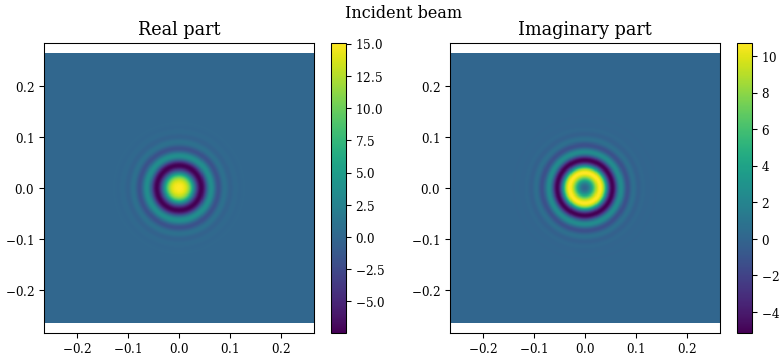

In [4]:
N, M = 801, 801
q_inc = q_eig # input beam is perfectly mode matched
q_to_ETM = of.q_propag(q_inc, md)
w_ITM = of.q.get_w(q_inc)
w_ETM = of.q.get_w(q_to_ETM)

w_scl = 5

xs_ITM = np.linspace(-1, 1, N) * w_scl*w_ITM
ys_ITM = np.linspace(-1, 1, M) * w_scl*w_ITM
dx_ITM = xs_ITM[1] - xs_ITM[0]
dy_ITM = ys_ITM[1] - ys_ITM[0]

xs_ETM = np.linspace(-1, 1, N) * w_scl*w_ETM
ys_ETM = np.linspace(-1, 1, M) * w_scl*w_ETM
dx_ETM = xs_ETM[1] - xs_ETM[0]
dy_ETM = ys_ETM[1] - ys_ETM[0]

P_in = 1
U_inc = np.sqrt(P_in) * of.u_nm_q(xs_ITM, ys_ITM, q_inc, q_inc, 0, 0, include_gouy=False)

fig, ax = plt.subplots(1,2,figsize=[10,4])
plt.sca(ax[0])
plt.pcolormesh(xs_ITM,ys_ITM, np.real(U_inc))
plt.axis('equal')
plt.colorbar()
plt.title('Real part')
plt.sca(ax[1])
plt.pcolormesh(xs_ITM,ys_ITM, np.imag(U_inc))
plt.axis('equal')
plt.colorbar()
plt.title('Imaginary part')
plt.suptitle('Incident beam')

## Define aperture mirror map

/tmp/ipykernel_45923/4212683114.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xs_ITM,ys_ITM, ap_map_ITM)
/tmp/ipykernel_45923/4212683114.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_45923/4212683114.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xs_ETM,ys_ETM, ap_map_ETM)
/tmp/ipykernel_45923/4212683114.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorb

Text(0.5, 1.0, 'ETM mirror map')

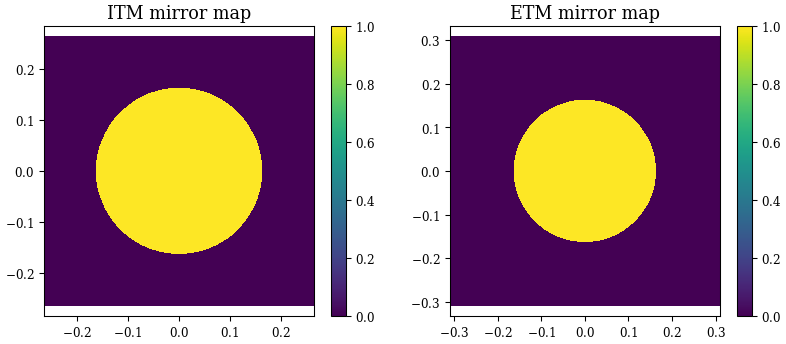

In [5]:
ap_map_ITM = np.ones([M, N], dtype=float)
ap_map_ITM[np.add.outer(ys_ITM**2, xs_ITM**2) > TM_aperture_radius**2] = 0

ap_map_ETM = np.ones([M, N], dtype=float)
ap_map_ETM[np.add.outer(ys_ETM**2, xs_ETM**2) > TM_aperture_radius**2] = 0

fig, ax = plt.subplots(1,2,figsize=[10,4])
plt.sca(ax[0])
plt.pcolormesh(xs_ITM,ys_ITM, ap_map_ITM)
plt.axis('equal')
plt.colorbar()
plt.title('ITM mirror map')
plt.sca(ax[1])
plt.pcolormesh(xs_ETM,ys_ETM, ap_map_ETM)
plt.axis('equal')
plt.colorbar()
plt.title('ETM mirror map')

ETM aperture looks smaller because the grid at the ETM is bigger than it is at the ITM

## Define LCT operators

In [6]:
D_x_ITM_to_ETM = lctf.LCT1D(xs_ITM, xs_ETM, M_abcd=md)
D_y_ITM_to_ETM = lctf.LCT1D(ys_ITM, ys_ETM, M_abcd=md)

D_x_ETM_to_ITM = lctf.LCT1D(xs_ETM, xs_ITM, M_abcd=md)
D_y_ETM_to_ITM = lctf.LCT1D(ys_ETM, ys_ITM, M_abcd=md)

C_x_ETM = lctf.CM_kernel(xs_ETM, -2/RoC_ETM, diag=True)
C_y_ETM = lctf.CM_kernel(ys_ETM, -2/RoC_ETM, diag=True)
Rc_map_ETM = np.outer(C_y_ETM, C_x_ETM)

C_x_ITM = lctf.CM_kernel(xs_ITM, -2/RoC_ITM, diag=True)
C_y_ITM = lctf.CM_kernel(ys_ITM, -2/RoC_ITM, diag=True)
Rc_map_ITM = np.outer(C_y_ITM, C_x_ITM)

/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../arm_cav_LCT_Dy1.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../arm_cav_LCT_Dy1.pdf


0

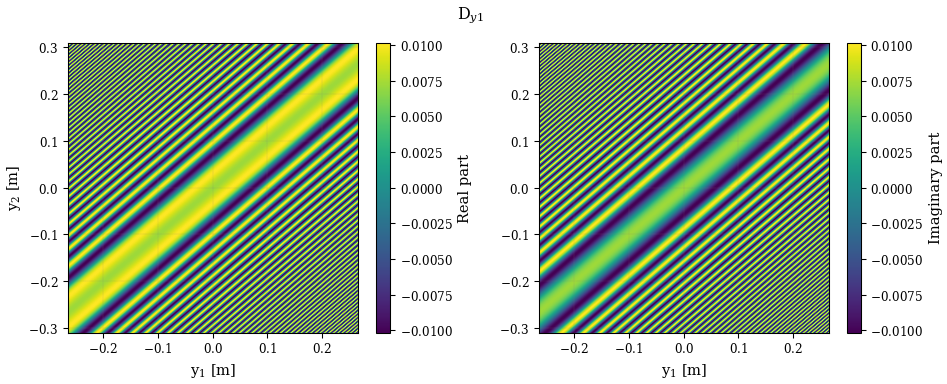

In [74]:
fig, axs = mpf.complex_imshow(xs_ITM, xs_ETM, D_x_ITM_to_ETM, xlabel='y$_1$ [m]', ylabel='y$_2$ [m]', interpolation='lanczos')
plt.suptitle('D$_{y1}$')
mpf.thesis_savefig(fig, '../arm_cav_LCT_Dy1', resize=False)

/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../arm_cav_LCT_Dy2.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../arm_cav_LCT_Dy2.pdf


0

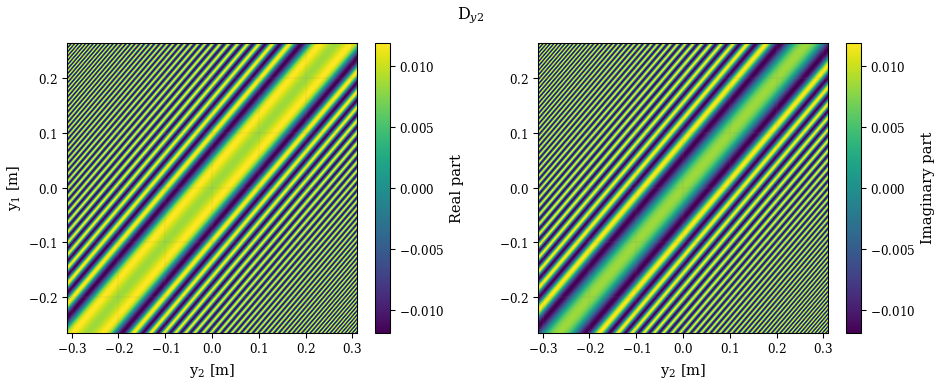

In [75]:
mpf.complex_imshow(xs_ETM, xs_ITM, D_x_ETM_to_ITM, xlabel='y$_2$ [m]', ylabel='y$_1$ [m]', interpolation='lanczos')
plt.suptitle('D$_{y2}$')
mpf.thesis_savefig(fig, '../arm_cav_LCT_Dy2', resize=False)

/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../arm_cav_ITM_map.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../arm_cav_ITM_map.pdf


0

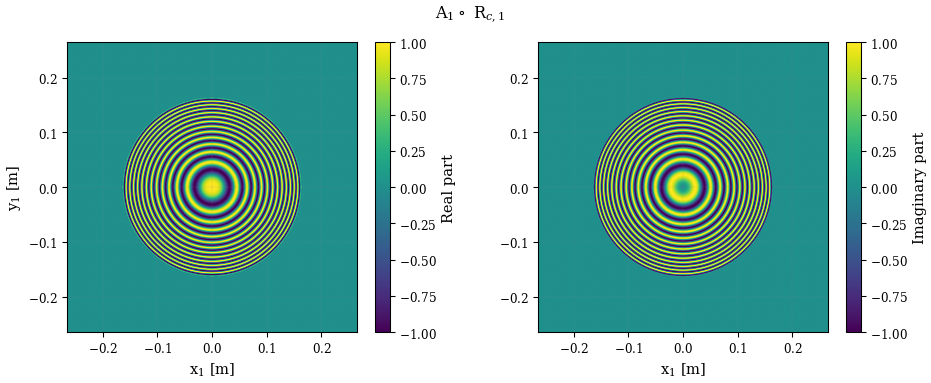

In [76]:
fig, ax = mpf.complex_imshow(xs_ITM, xs_ITM, Rc_map_ITM*ap_map_ITM, xlabel='x$_1$ [m]', ylabel='y$_1$ [m]', interpolation='lanczos', clim_re=[-1,1], clim_im=[-1,1])
plt.suptitle('A$_1 \circ$ R$_{c,1}$')
mpf.thesis_savefig(fig, '../arm_cav_ITM_map', resize=False)

/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../arm_cav_ETM_map.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../arm_cav_ETM_map.pdf


0

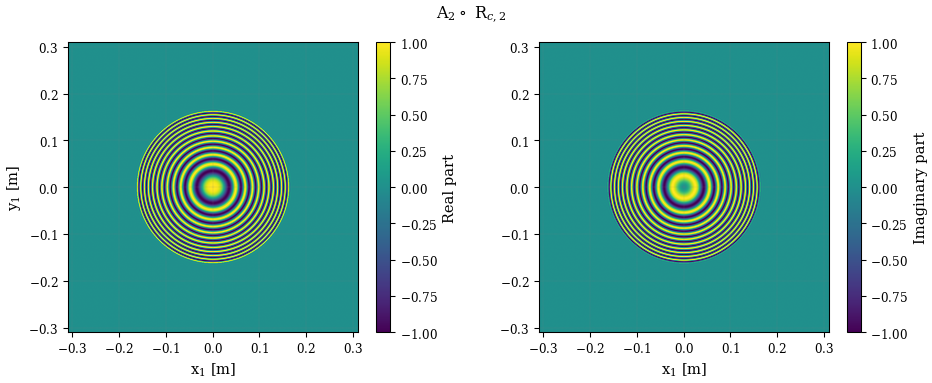

In [10]:
fig, ax = mpf.complex_imshow(xs_ETM, xs_ETM, Rc_map_ETM*ap_map_ETM, xlabel='x$_1$ [m]', ylabel='y$_1$ [m]', interpolation='lanczos', clim_re=[-1,1], clim_im=[-1,1])
plt.suptitle('A$_2 \circ$ R$_{c,2}$')
mpf.thesis_savefig(fig, '../arm_cav_ETM_map', resize=False)

## Compute circulating field on resonance

In [7]:
# normalize the eigenvalue to use it for putting the cavity on resonance
cavity_phase_tuning = np.conj(g_rt)

def op_rt(v):
    '''Round trip operator. Put in mirror reflectivities and put the cavity on resonance.
    '''
    Xin = np.reshape(v, [M,N])
    X1 = D_y_ITM_to_ETM@Xin@D_x_ITM_to_ETM.T
    X2 = ap_map_ETM*Rc_map_ETM*X1*r_ETM
    X3 = D_y_ETM_to_ITM@X2@D_x_ETM_to_ITM.T
    X4 = ap_map_ITM*Rc_map_ITM*X3*r_ITM*cavity_phase_tuning
    return np.ravel(X4)

def op_circ(v):
    '''Circulating operator is identity operator minus round trip operator.
    '''
    return v - op_rt(v)

linop_rt = scipy.sparse.linalg.LinearOperator(matvec=op_rt, shape=[N*M,N*M])
linop_circ = scipy.sparse.linalg.LinearOperator(matvec=op_circ, shape=[N*M,N*M])

In [8]:
U_inc_at_ITM = U_inc * 1j*t_ITM * ap_map_ITM

# krylov solvers only take in 1D arrays
U_in = np.ravel(U_inc_at_ITM)

U_circ, _ = scipy.sparse.linalg.gmres(linop_circ, U_in)

# reshape 1D output from krylov solver back into 2D
U_circ = np.reshape(U_circ, [M,N])

In [9]:
incident_power = np.sum(np.abs(U_inc)**2)*dx_ITM*dy_ITM
circulating_power = np.sum(np.abs(U_circ)**2)*dx_ITM*dy_ITM
planewave_circulating_power = (t_ITM/(1-r_ETM*r_ITM))**2

print(f'Incident power onto cavity is {incident_power:.5g} W')
print(f'LCT circulating power inside apertured cavity on resonance is {circulating_power:.5g} W')
print(f'Planewave approximation to circulating power on resonance without apertures is {planewave_circulating_power:.5g} W')

Incident power onto cavity is 1 W
LCT circulating power inside apertured cavity on resonance is 283.43 W
Planewave approximation to circulating power on resonance without apertures is 283.51 W


## Propagate circulating field to ETM

In [10]:
# propagate solved field to ETM
U_circ_to_ETM = D_y_ITM_to_ETM@U_circ@D_x_ITM_to_ETM.T

# apply aperture from ETM (ignore curvature and reflection coefficient)
U_circ_from_ETM = ap_map_ETM*U_circ_to_ETM

# compute the difference
U_circ_ETM_to_from_difference = U_circ_to_ETM - U_circ_from_ETM

(<Figure size 1075.2x384 with 4 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

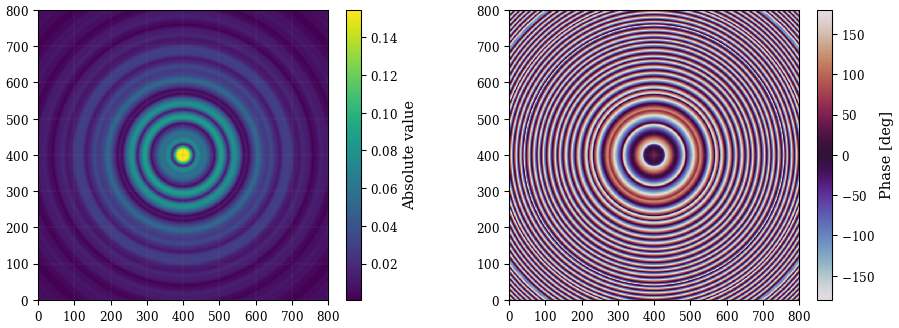

In [11]:
u00 = of.u_nm_q(xs_ETM, ys_ETM, q_eig + len_ARM, include_gouy=False)*1j  * of.accum_gouy_Siegman(q_eig, md) * np.sqrt(circulating_power)

mpf.complex_imshow(U_circ_to_ETM-u00, mode='abs:deg')

In [16]:
phis = np.linspace(0, 2*np.pi, 101)
ap_x, ap_y = np.vstack([np.cos(phis), np.sin(phis)])*TM_aperture_radius

/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../U_circ_ETM.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../U_circ_ETM.pdf


0

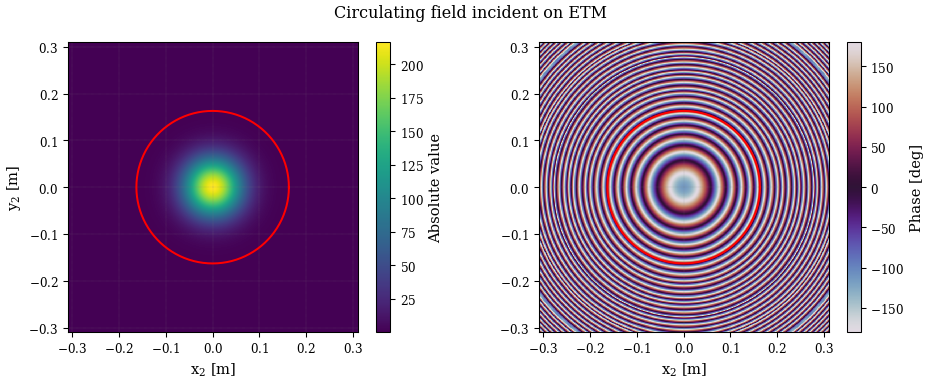

In [21]:
fig, ax = mpf.complex_imshow(xs_ETM, xs_ETM, U_circ_to_ETM, interpolation='lanczos', xlabel='x$_2$ [m]', ylabel='y$_2$ [m]', mode='abs:deg')
ax[0].plot(ap_x, ap_y, c='r')
ax[1].plot(ap_x, ap_y, c='r')
plt.suptitle('Circulating field incident on ETM')
mpf.thesis_savefig(fig, '../U_circ_ETM', resize=False)

/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../U_circ_ETM_outside_aperute.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../U_circ_ETM_outside_aperute.pdf


0

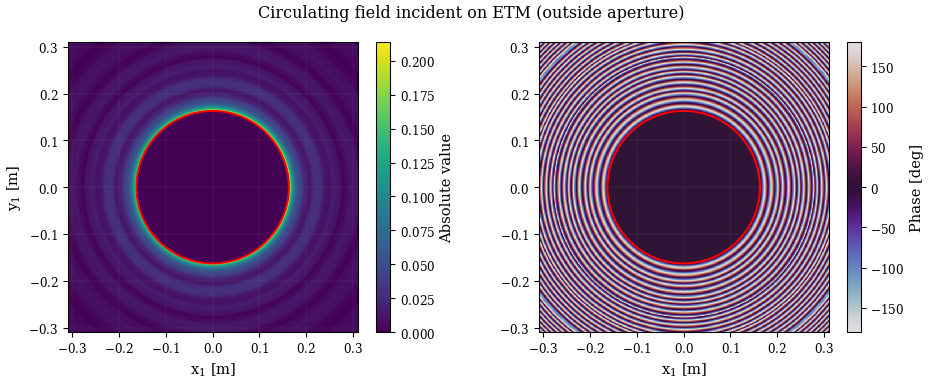

In [22]:
fig, ax = mpf.complex_imshow(xs_ETM, xs_ETM, U_circ_ETM_to_from_difference, interpolation='lanczos', mode='abs:deg', xlabel='x$_1$ [m]', ylabel='y$_1$ [m]')
plt.suptitle('Circulating field incident on ETM (outside aperture)')
ax[0].plot(ap_x, ap_y, c='r')
ax[1].plot(ap_x, ap_y, c='r')
mpf.thesis_savefig(fig, '../U_circ_ETM_outside_aperute', resize=False)

## compute power in the diffraction rings on resonance outside of ETM

In [24]:
hiro = np.array([
[0, 50048.802711379496],
[0.005921454338785033, 2395.141892119621],
[0.008609491205724311, 590.9719100115357],
[0.01175492035284398, 116.90838054390841],
[0.014557461148170083, 26.797156585416133],
[0.01684587722692813, 7.474929095967178],
[0.01930469842597146, 2.19027585120506],
[0.021809404320818446, 0.6170567436113384],
[0.023765364166122342, 0.22330419055438952],
[0.026409345075134205, 0.04616280863959566],
[0.028228523639740807, 0.016952810907145274],
[0.030457921359765903, 0.006045896415390788],
[0.03405346939778549, 0.0022660592547119668],
[0.036106955002784366, 0.0014753703528864682],
[0.037763729175314203, 0.0007698714214151001],
[0.0403226322108568, 0.00029999458241849943],
[0.042103531966735906, 0.0001792026689453447],
[0.04431861150043459, 0.0003473780121417512],
[0.04636160264375736, 0.0007822088457025264],
[0.04841030859294335, 0.0008961647126521138],
[0.050459637975496255, 0.0009537612023959073],
[0.05250959079141604, 0.0009429271950630006],
[0.054563492018659523, 0.0005844747440336962],
[0.05662061431829864, 0.0002475433533958371],
[0.05867358039549175, 0.0001713794769270094],
[0.06072581913375684, 0.00012930496765918564],
[0.06277514851630973, 0.0001376153955732274],
[0.06492181662854755, 0.00026938961320440607],
[0.06686798856999115, 0.0003101426405715084],
[0.06892033121381738, 0.0002311438414287857],
[0.07097215432983787, 0.00018318121105550685],
[0.07302325010693031, 0.00015820797769005153],
[0.07511482749064663, 0.00006474117725779131],
[0.07603758364457584, 0.000030785465846210705],
[0.07663209805677704, 0.000012305194045829543],
[0.07762003418633329, 0.0000016963302645513145],
[0.07817842061780489, 0.000004280669152783523],
[0.07886986094477949, 0.000011243625305147221],
[0.08021361884404143, 0.000024221350417217057],
[0.0821566320564261, 0.00004051163054909455],
[0.08430261439196032, 0.00008600192673391013],
[0.08634654068533343, 0.00017338384240802278],
[0.08839483101227484, 0.0002086488242323743],
[0.09044634241161187, 0.000171562036459612],
[0.09249702256645971, 0.0001556362823003146],
[0.09454687147681835, 0.00015577039035820933],
[0.09659838287615538, 0.00012808260716676745],
[0.09865332315901036, 0.0000702137617940831],
[0.099853536295849, 0.00004142015969082195],
]).T

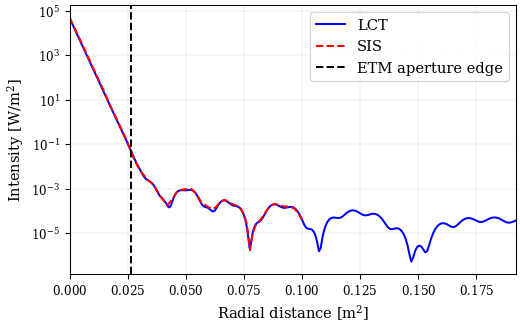

In [25]:
xs_ETM_diag = xs_ETM*np.sqrt(2)

fig = plt.figure()
plt.semilogy(xs_ETM_diag[N//2:]**2, np.abs(np.diag(U_circ_to_ETM)[N//2:])**2, label='LCT')
plt.semilogy(*hiro, '--', label='SIS')
plt.ylabel('Intensity [W/m$^2$]')
plt.xlabel('Radial distance [m$^2$]')
plt.axvline(TM_aperture_radius**2, c='k', ls='--', label='ETM aperture edge')
plt.legend()

In [26]:
sol10x, sol10y = gef.load_uncompressed('sol10.pkl')
sol30x, sol30y = gef.load_uncompressed('sol30.pkl')
sol60x, sol60y = gef.load_uncompressed('sol60.pkl')

In [27]:
np.sqrt(0.1)*2

0.63245553203367588

In [28]:
np.ptp(xs_ETM)

0.6196339887356086

/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../U_circ_ETM_cross_section.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/hiro_arm_cavity_aperture_scatter/../U_circ_ETM_cross_section.pdf


0

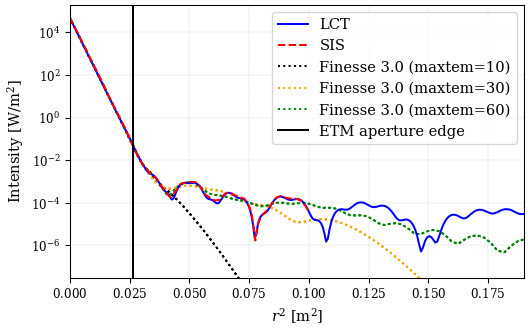

In [29]:
fig, ax = plt.subplots()
plt.semilogy(xs_ETM_diag[N//2:]**2, np.abs(np.diag(U_circ_to_ETM)[N//2:])**2, label='LCT')
#plt.semilogy(ys_ETM**2, np.abs(U_circ_from_ETM[:, 300])**2, label='From ETM LCT')
plt.semilogy(*hiro, ls='--', label='SIS')
plt.semilogy(sol10x, sol10y, ls=':', label='Finesse 3.0 (maxtem=10)', zorder=-99)
plt.semilogy(sol30x, sol30y, ls=':', label='Finesse 3.0 (maxtem=30)', zorder=-99)
plt.semilogy(sol60x, sol60y, ls=':', label='Finesse 3.0 (maxtem=60)', zorder=-99)
plt.axvline(TM_aperture_radius**2, c='k', ls='-', label='ETM aperture edge')
plt.xlim(0, None)
plt.ylabel('Intensity [W/m$^2$]')
plt.xlabel('$r^2$ [m$^2$]')
plt.legend()
plt.ylim(3e-8, 2e5)
plt.xlim(None, 0.19)
mpf.thesis_savefig(fig, '../U_circ_ETM_cross_section')